In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats.mstats import winsorize

In [2]:
file_ = 'data/winequalityN.csv'
try: # Running Locally, yakinkan "file_" berada di folder "data"

    df = pd.read_csv(file_)
except: # Running in Google Colab
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/dazzerz/Regresi-Logistik-Wine-Dataset/main/winequalityN.csv

    df = pd.read_csv(file_, low_memory=False, encoding = 'utf8')

N, P = df.shape # Ukuran Data
print('baris = ', N, ', Kolom (jumlah variabel) = ', P)
df

baris =  6497 , Kolom (jumlah variabel) =  13


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


About Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [4]:
print(*df.columns, sep='\n')

type
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
quality


In [5]:
df.columns = ('type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality')

In [6]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


<Axes: >

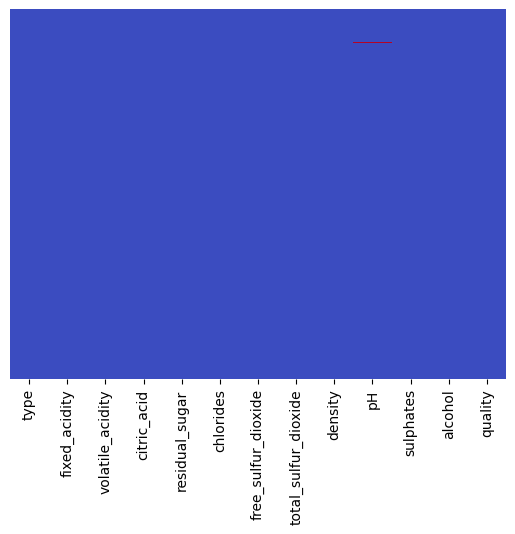

In [7]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

In [8]:
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
type,0,0.000000
fixed_acidity,10,0.001539
volatile_acidity,8,0.001231
citric_acid,3,0.000462
residual_sugar,2,0.000308
chlorides,2,0.000308
free_sulfur_dioxide,0,0.000000
total_sulfur_dioxide,0,0.000000
density,0,0.000000
pH,9,0.001385


In [9]:
def null_cell(df):
    total_missing_values = df.isnull().sum()
    missing_values_per = df.isnull().sum()/df.isnull().count()
    null_values = pd.concat([total_missing_values, missing_values_per], axis=1, keys=['total_null', 'total_null_perc'])
    null_values = null_values.sort_values('total_null', ascending=False)
    return null_values[null_values['total_null'] > 0]

In [10]:
fill_list = (null_cell(df)).index

In [11]:
df_mean = df.copy()

for col in fill_list:
    df_mean.loc[:, col].fillna(df_mean.loc[:, col].mean(), inplace=True)


<Axes: >

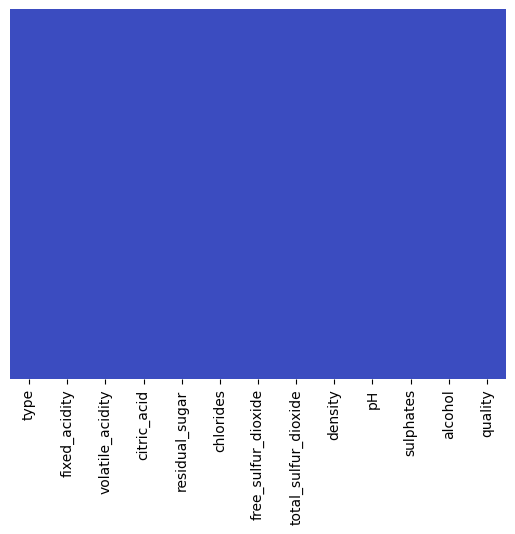

In [12]:
sns.heatmap(df_mean.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

<ipython-input-13-33f725e823f6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_mean.corr()


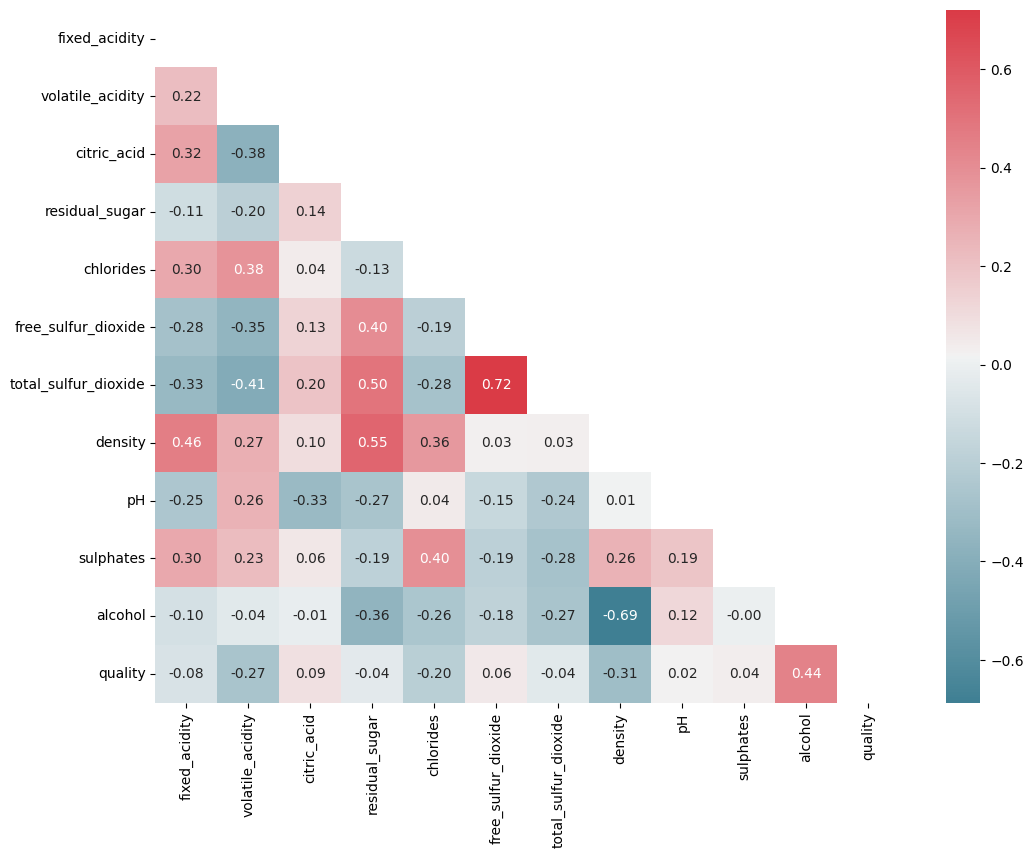

In [13]:
corr_matrix = df_mean.corr()
corr_list = corr_matrix.quality.abs().sort_values(ascending=False).index[0:]
plt.figure(figsize=(12,9))
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)

sns.set(font_scale=1)

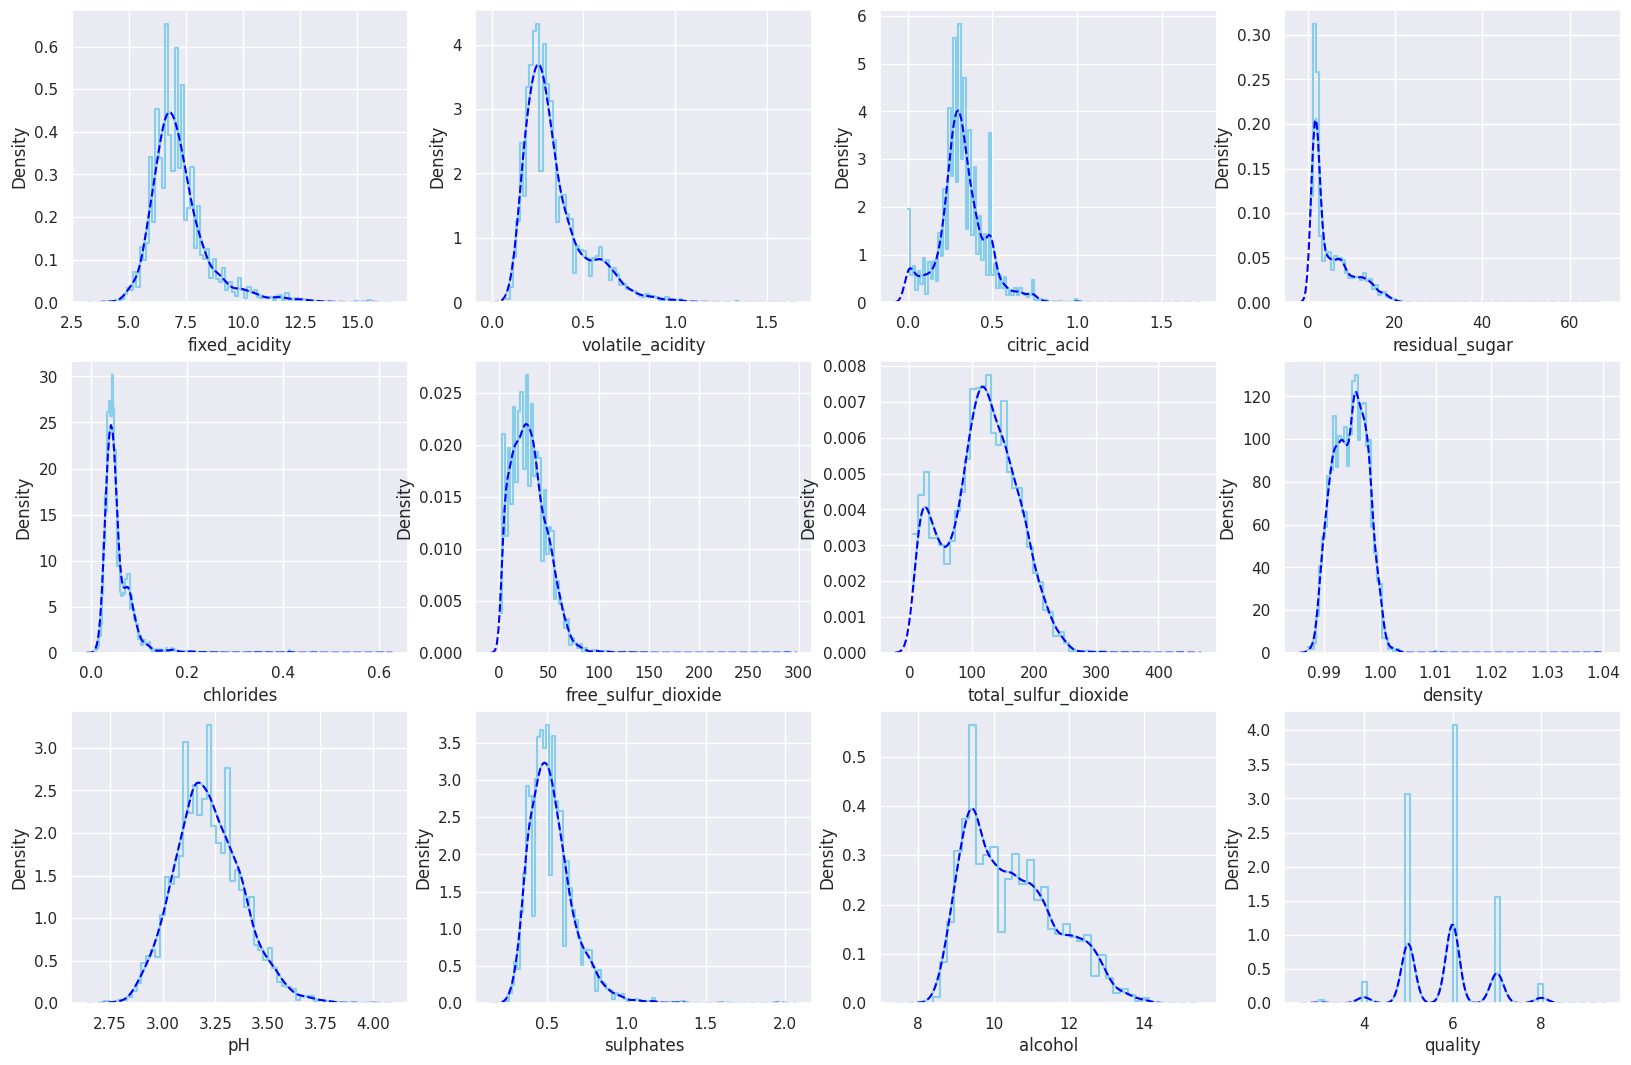

In [14]:
plt.figure(figsize=(20, 22))

for i in range(1, 13):
    plt.subplot(5, 4, i)
    sns.histplot(df_mean[df_mean.columns[i]], kde=True, stat="density", common_norm=False, color="skyblue", element="step", fill=False)
    sns.kdeplot(df_mean[df_mean.columns[i]], color="blue", linestyle="--", ax=plt.gca())

# Show the plot
plt.show()

In [15]:
df_bins= df_mean.copy()

In [16]:
bins = [0,5,10]


labels = [0, 1] # 'low'=0, 'high'=1
df_bins['quality_range']= pd.cut(x=df_bins['quality'], bins=bins, labels=labels)

print(df_bins[['quality_range','quality']].head(5))

df_bins = df_bins.drop('quality', axis=1)

  quality_range  quality
0             1        6
1             1        6
2             1        6
3             1        6
4             1        6


Low Quality  0   : %63.31
High Quality 1   : %36.69


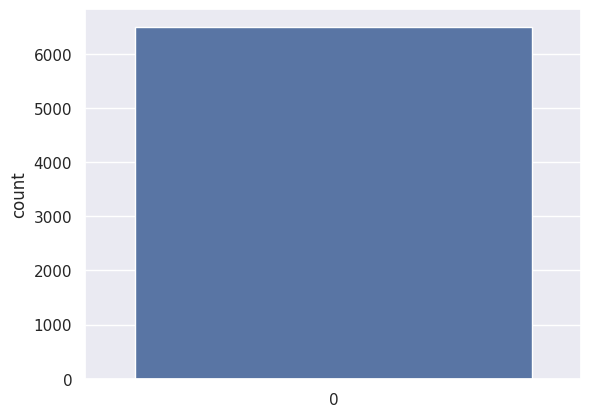

In [17]:
sns.countplot(df_bins.quality_range)
 #'low'=0, 'high'=1

print("Low Quality  0   : %{:.2f}".format(sum(df_bins.quality_range)/len(df_bins.quality_range)*100))
print("High Quality 1   : %{:.2f}".format((len(df_bins.quality_range)-sum(df_bins.quality_range))/len(df_bins.quality_range)*100))

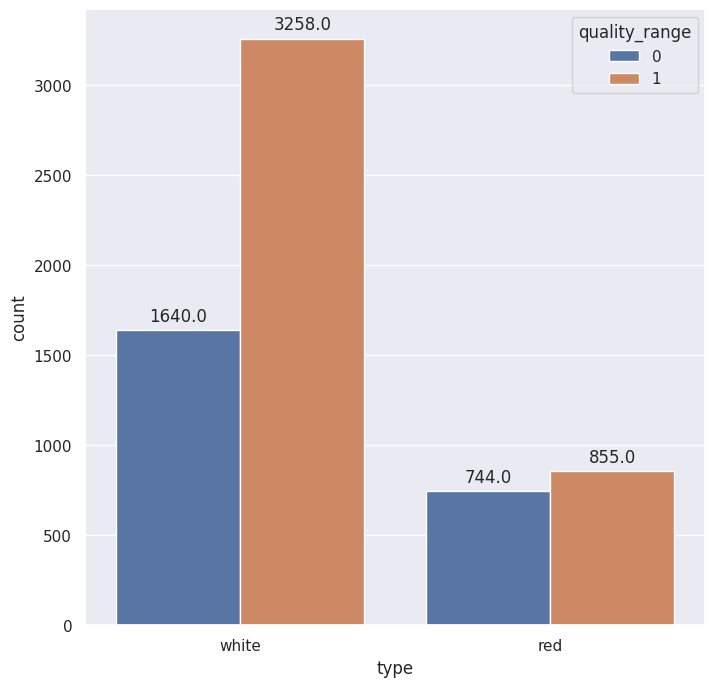

In [18]:
plt.figure(figsize=(8, 8))

ax = sns.countplot(x='type', hue='quality_range', data=df_bins)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

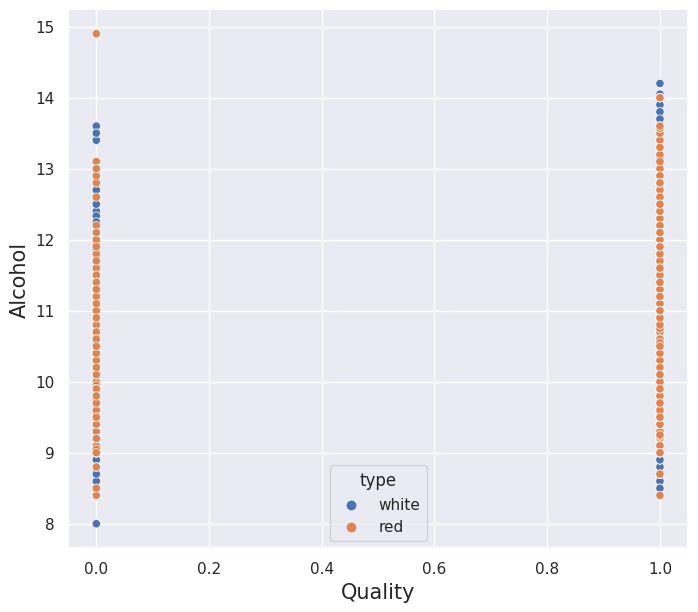

In [19]:
plt.figure(figsize=(8,7))
sns.scatterplot(x='quality_range',
                y='alcohol',
                hue='type',
                data=df_bins);
plt.xlabel('Quality',size=15)
plt.ylabel('Alcohol', size =15)
plt.show()

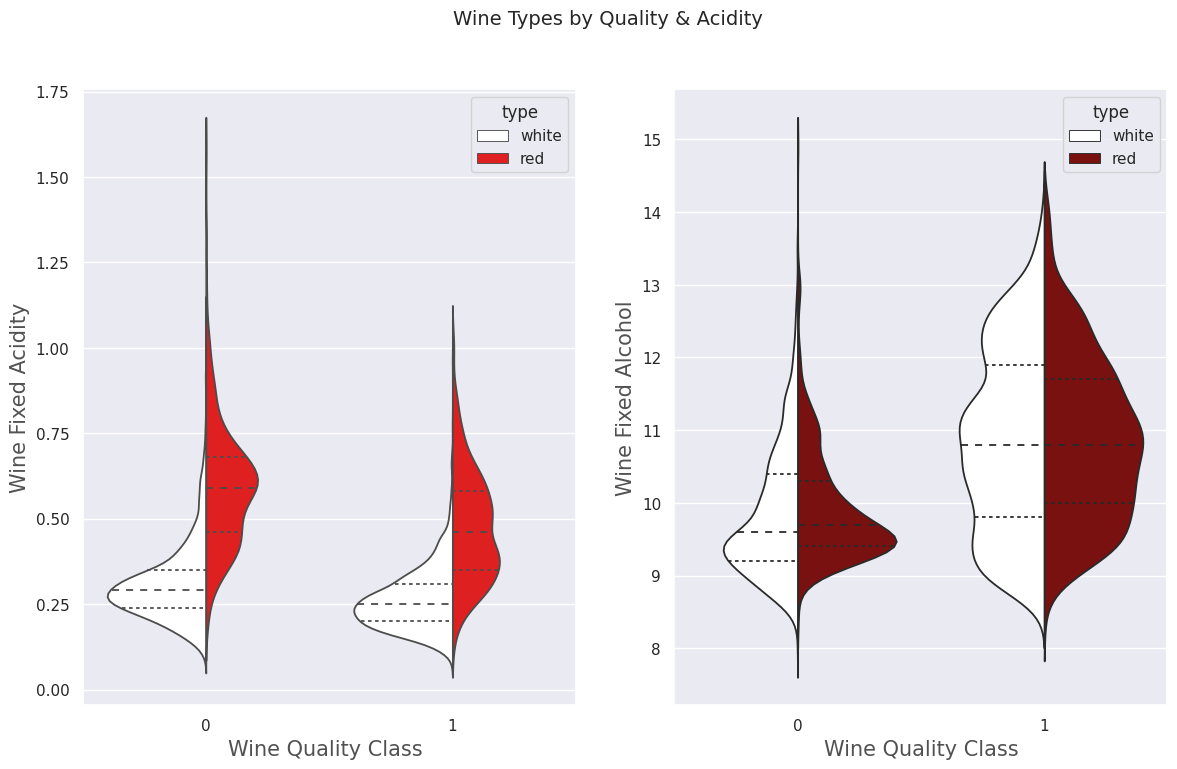

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
f.suptitle('Wine Types by Quality & Acidity', fontsize=14)

sns.violinplot(x='quality_range', y='volatile_acidity', hue='type', data=df_bins, split=True, inner='quart', linewidth=1.3,
               palette={'red': 'red', 'white': 'white'}, ax=ax1)
ax1.set_xlabel("Wine Quality Class ",size = 15,alpha=0.8)
ax1.set_ylabel("Wine Fixed Acidity",size = 15,alpha=0.8)

sns.violinplot(x='quality_range', y='alcohol', hue='type', data=df_bins, split=True, inner='quart', linewidth=1.3,
               palette={'red': 'darkred', 'white': 'white'}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 15,alpha=0.8)
ax2.set_ylabel("Wine Fixed Alcohol",size = 15,alpha=0.8)
plt.show()

<ipython-input-21-24e95e5254b8>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data= low_quality, label= 'low_quality', shade=True, color=None)
<ipython-input-21-24e95e5254b8>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data= high_quality,label= 'high_quality',shade=True, color= "r")


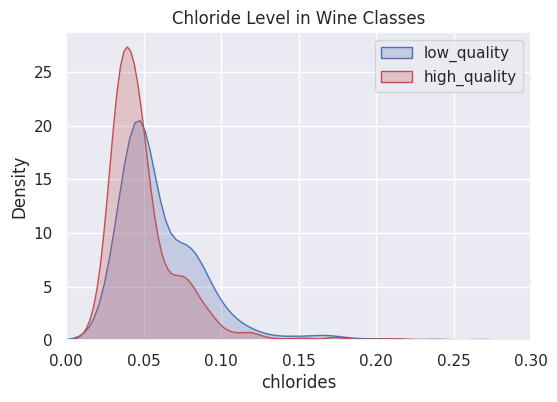

In [21]:
plt.figure(figsize= (6,4))

low_quality = df_bins [df_bins['quality_range']== 0]['chlorides']
high_quality   = df_bins [df_bins['quality_range']== 1][ 'chlorides']
ax = sns.kdeplot(data= low_quality, label= 'low_quality', shade=True, color=None)
ax = sns.kdeplot(data= high_quality,label= 'high_quality',shade=True, color= "r")

plt.title("Chloride Level in Wine Classes")
plt.xlim(0.0,0.3)
plt.legend()
plt.show()

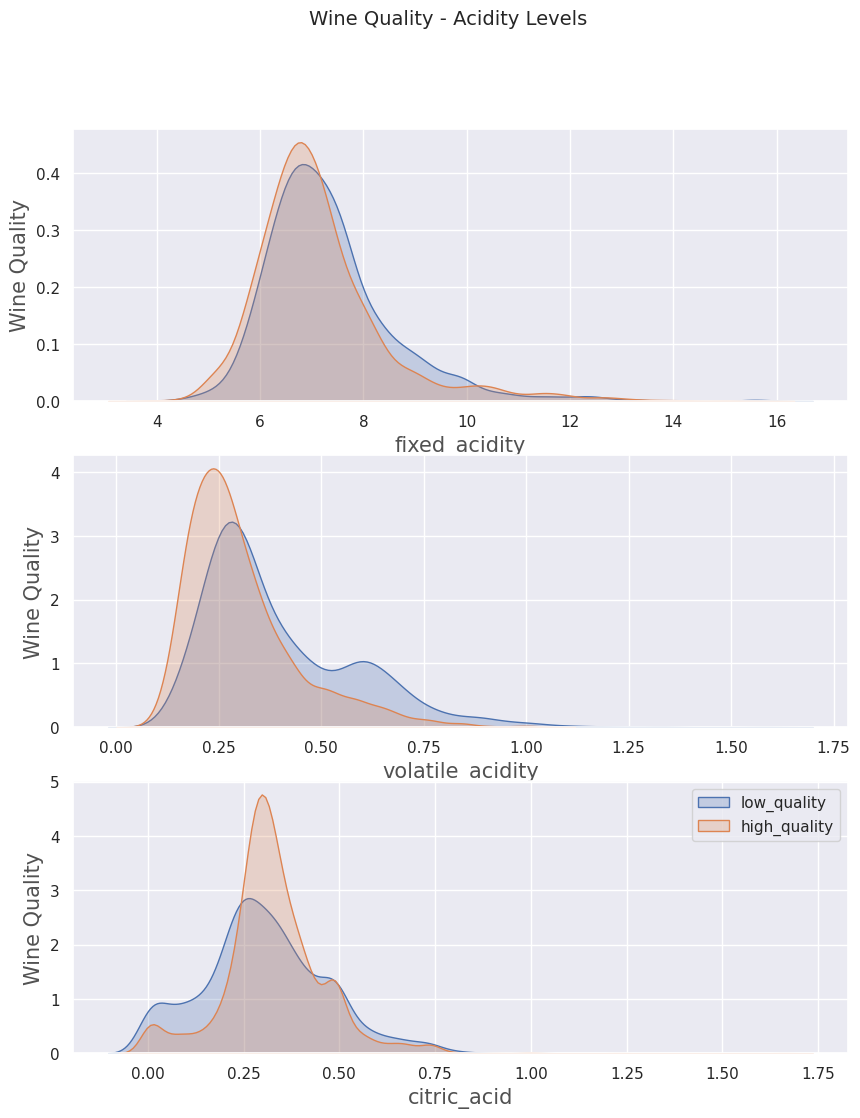

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12))

f.suptitle('Wine Quality - Acidity Levels', fontsize=14)

fixed_acidity_low_quality = df_bins[df_bins['quality_range'] == 0]['fixed_acidity']
fixed_acidity_high_quality = df_bins[df_bins['quality_range'] == 1]['fixed_acidity']

volatile_acidity_low_quality = df_bins[df_bins['quality_range'] == 0]['volatile_acidity']
volatile_acidity_high_quality = df_bins[df_bins['quality_range'] == 1]['volatile_acidity']

citric_acid_low_quality = df_bins[df_bins['quality_range'] == 0]['citric_acid']
citric_acid_high_quality = df_bins[df_bins['quality_range'] == 1]['citric_acid']

sns.kdeplot(data=fixed_acidity_low_quality, label="low_quality", fill=True, ax=ax1)
sns.kdeplot(data=fixed_acidity_high_quality, label="high_quality", fill=True, ax=ax1)
ax1.set_xlabel("fixed_acidity", size=15, alpha=0.8)
ax1.set_ylabel("Wine Quality", size=15, alpha=0.8)

sns.kdeplot(data=volatile_acidity_low_quality, label="low_quality", fill=True, ax=ax2)
sns.kdeplot(data=volatile_acidity_high_quality, label="high_quality", fill=True, ax=ax2)
ax2.set_xlabel("volatile_acidity", size=15, alpha=0.8)
ax2.set_ylabel("Wine Quality", size=15, alpha=0.8)

sns.kdeplot(data=citric_acid_low_quality, label="low_quality", fill=True, ax=ax3)
sns.kdeplot(data=citric_acid_high_quality, label="high_quality", fill=True, ax=ax3)
ax3.set_xlabel("citric_acid", size=15, alpha=0.8)
ax3.set_ylabel("Wine Quality", size=15, alpha=0.8)

plt.legend()
plt.show()

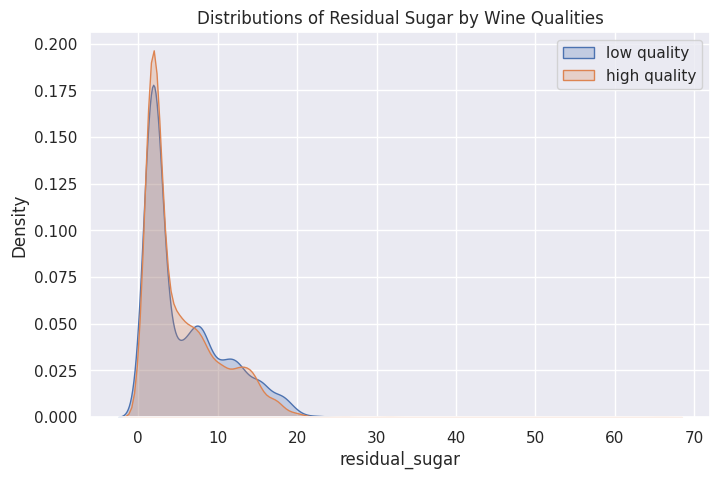

In [23]:
plt.figure(figsize=(8,5))

residual_sugar_low   = df_bins [df_bins['quality_range']== 0]['residual_sugar']
residual_sugar_high  = df_bins [df_bins['quality_range']== 1]['residual_sugar']
ax = sns.kdeplot(data= residual_sugar_low, label= 'low quality', fill=True)
ax = sns.kdeplot(data= residual_sugar_high,   label= 'high quality',   fill=True)

plt.title("Distributions of Residual Sugar by Wine Qualities")
plt.legend()
plt.show()

Text(0, 0.5, 'free_sulfur_dioxide')

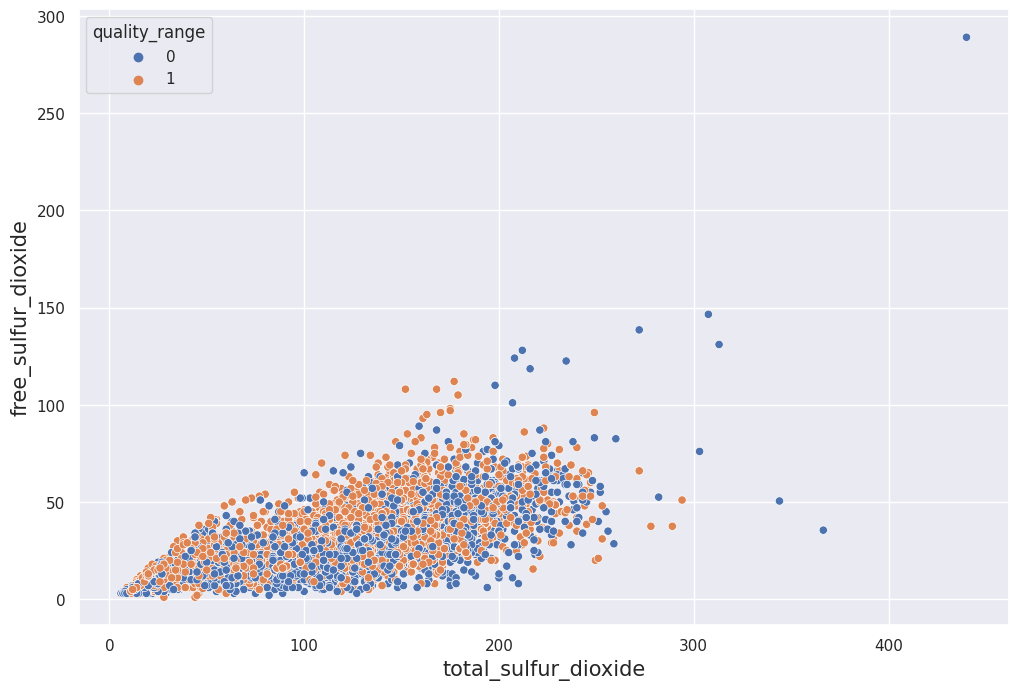

In [24]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='total_sulfur_dioxide', y='free_sulfur_dioxide', hue='quality_range',data=df_bins);
plt.xlabel('total_sulfur_dioxide',size=15)
plt.ylabel('free_sulfur_dioxide', size =15)

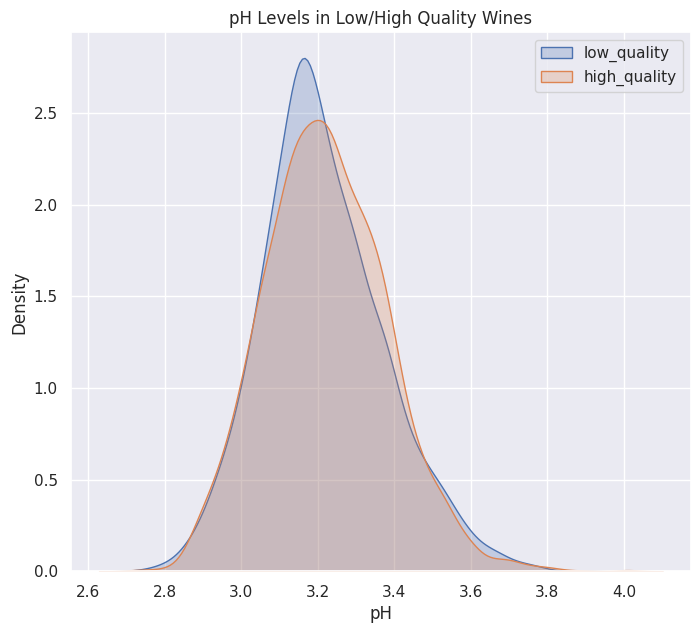

In [25]:
plt.figure(figsize=(8,7))

pH_low_quality  = df_bins [df_bins['quality_range']== 0]['pH']
pH_high_quality = df_bins [df_bins['quality_range']== 1][ 'pH']
ax = sns.kdeplot(data= pH_low_quality, label= 'low_quality', fill=True)
ax = sns.kdeplot(data= pH_high_quality,label= 'high_quality',   fill=True)

plt.title("pH Levels in Low/High Quality Wines")
plt.xlabel('pH')
plt.legend()
plt.show()

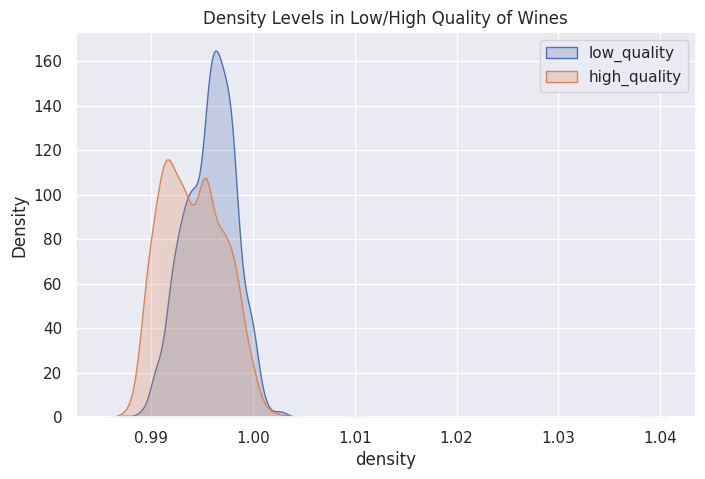

In [26]:
plt.figure(figsize=(8,5))

density_low_quality  = df_bins [df_bins['quality_range']== 0]['density']
density_high_quality = df_bins [df_bins['quality_range']== 1][ 'density']
ax = sns.kdeplot(data= density_low_quality, label= 'low_quality', fill=True)
ax = sns.kdeplot(data= density_high_quality,label= 'high_quality', fill=True)

plt.title("Density Levels in Low/High Quality of Wines")
plt.xlabel('density')
plt.legend()
plt.show()

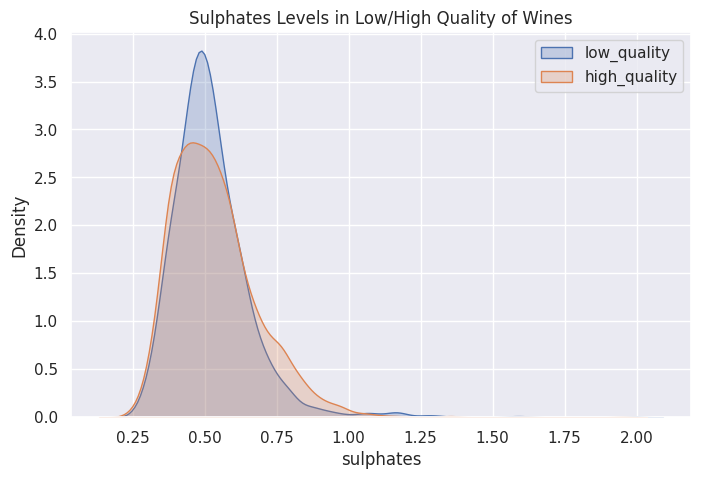

In [27]:
plt.figure(figsize=(8,5))

sulphates_low_quality    = df_mean [df_bins['quality_range']== 0]['sulphates']
sulphates_high_quality   = df_mean [df_bins['quality_range']== 1][ 'sulphates']
ax = sns.kdeplot(data= sulphates_low_quality, label= 'low_quality',  fill=True)
ax = sns.kdeplot(data= sulphates_high_quality,label= 'high_quality', fill=True)

plt.title("Sulphates Levels in Low/High Quality of Wines")
plt.xlabel('sulphates')
plt.legend()
plt.show()

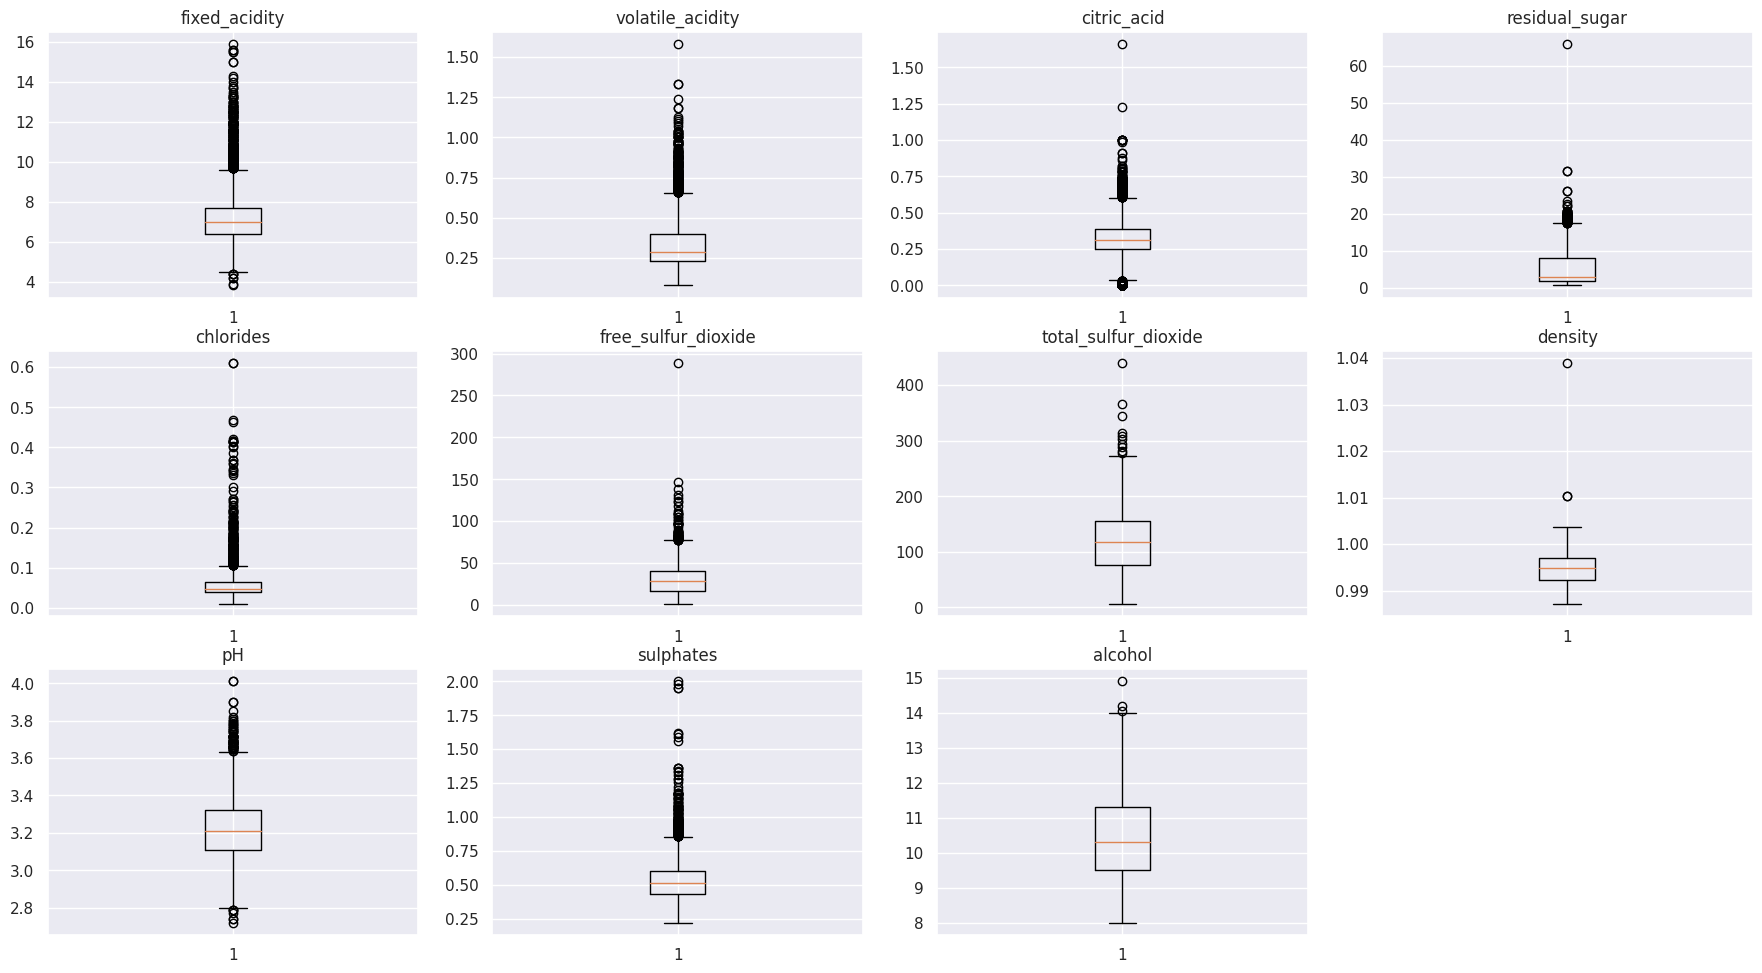

In [28]:
outliers_by_12_variables = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
                            'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
                            'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
plt.figure(figsize=(22,20))

for i in range(0,11):
    plt.subplot(5, 4, i+1)
    plt.boxplot(df_bins[outliers_by_12_variables[i]])
    plt.title(outliers_by_12_variables[i])

In [29]:
def winsor(x, multiplier=3):
    upper= x.median() + x.std()*multiplier
    for limit in np.arange(0.001, 0.20, 0.001):
        if np.max(winsorize(x,(0,limit))) < upper:
            return limit
    return None

In [30]:
kolom = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
                                  'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

for i in range(1,len(kolom)):

    df_bins[kolom[i]] = winsorize(df_bins[kolom[i]], (0, winsor(df_bins[kolom[i]])))

In [31]:
df_bins.type = df_bins.type.map({'white':0, 'red':1})

In [32]:
df_bins

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_range
0,0,7.0,0.270,0.36,17.2,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,1
1,0,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,1
2,0,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,1
3,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,1
4,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,0
6493,1,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,1
6494,1,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,1
6495,1,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,0


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [34]:
X = df_bins[['type', 'alcohol', 'density', 'volatile_acidity', 'chlorides',
       'citric_acid', 'fixed_acidity', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'sulphates', 'residual_sugar', 'pH']]
y = df_bins.quality_range

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

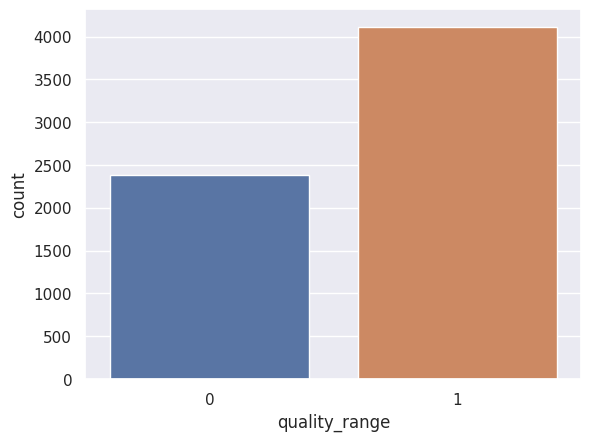

1    4113
0    2384
Name: quality_range, dtype: int64
Presentase 0 = 36.69385870401724 Presentase 1 = 63.30614129598276


In [35]:
# Visual Python: Visualization > Seaborn
from collections import Counter

sns.countplot(data=df_bins, x='quality_range')
plt.show()

# Menghitung frekuensi masing-masing nilai
value_counts = df_bins['quality_range'].value_counts()
print(value_counts)

# Menghitung presentase masing-masing nilai
percentage_0 = (value_counts[0] / len(df_bins['quality_range'])) * 100
percentage_1 = (value_counts[1] / len(df_bins['quality_range'])) * 100

print("Presentase 0 =", percentage_0, "Presentase 1 =", percentage_1)

In [36]:
from sklearn.preprocessing import StandardScaler
model = LogisticRegression(max_iter=1000)  # Sesuaikan nilai max_iter sesuai kebutuhan

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Penskalaan fitur-fitur pada data latih
X_train_scaled = scaler.fit_transform(X_train)

# Penskalaan fitur-fitur pada data uji menggunakan parameter yang sama dari data latih
X_test_scaled = scaler.transform(X_test)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [37]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print('Accuracy in Train Group   : {:.2f}'.format(train_accuracy),
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train Group   : 0.75
Accuracy in Test  Group   : 0.74


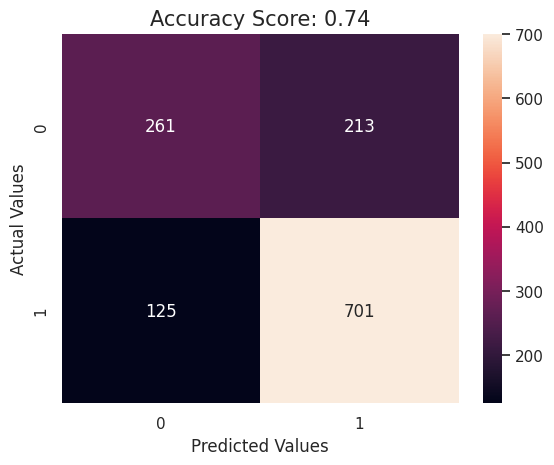

In [38]:
from sklearn.metrics import confusion_matrix as cm

predictions = model.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

In [39]:
pred_test  = model.predict(X_test)
pred_train = model.predict(X_train)

In [40]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test,pred_test)
cm

array([[261, 213],
       [125, 701]])

In [41]:
confusion_matrix_train = confusion_matrix(y_train,pred_train)
confusion_matrix_test = confusion_matrix(y_test,pred_test)

print('Confusion Matrix Train Data', '--'*20, confusion_matrix_train, sep='\n')
print('Confusion Matrix Test Data', '--'*20, confusion_matrix_test, sep='\n')

Confusion Matrix Train Data
----------------------------------------
[[1090  820]
 [ 494 2793]]
Confusion Matrix Test Data
----------------------------------------
[[261 213]
 [125 701]]


In [42]:
TN = confusion_matrix_test[0][0]
TP = confusion_matrix_test[1][1]
FP = confusion_matrix_test[0][1]
FN = confusion_matrix_test[1][0]

print("(Total) True Negative       :", TN)
print("(Total) True Positive       :", TP)
print("(Total) Negative Positive   :", FP)
print("(Total) Negative Negative   :", FN)

(Total) True Negative       : 261
(Total) True Positive       : 701
(Total) Negative Positive   : 213
(Total) Negative Negative   : 125


In [43]:
from sklearn.metrics import accuracy_score

print("Accuracy Score of Our Model     : ",  model.score(X_test, y_test))
#print("Accuracy Score of Our Model     : ",  accuracy_score(y_test, pred_test)) # same

Accuracy Score of Our Model     :  0.74


In [44]:
Error_Rate = 1- (accuracy_score(y_test, pred_test))
Error_Rate

0.26

In [45]:
from sklearn.metrics import precision_score

print("precision_score()         : ",  precision_score(y_test, pred_test, average='micro'))

precision_score()         :  0.74


In [46]:
from sklearn.metrics import recall_score

print("recall_score()            : ",  recall_score(y_test, pred_test, average='micro'))

recall_score()            :  0.74


In [47]:
print(" Specificity Score   : ",  (TN)/(TN + FP))

 Specificity Score   :  0.5506329113924051


In [48]:
from sklearn.metrics import f1_score

precision_s = precision_score(y_test, pred_test,average='micro')
recall_s    = recall_score(y_test, pred_test, average='micro')


print("F1_score     : ",  2*((precision_s*recall_s)/(precision_s + recall_s)))

F1_score     :  0.74


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.68      0.55      0.61       474
           1       0.77      0.85      0.81       826

    accuracy                           0.74      1300
   macro avg       0.72      0.70      0.71      1300
weighted avg       0.73      0.74      0.73      1300



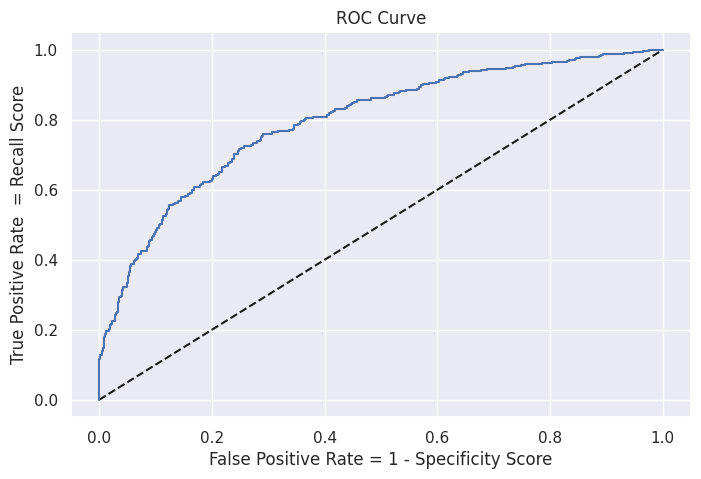

In [50]:
probs = model.predict_proba(X_test)[:,1]  #Predict probabilities for the test data

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds  = roc_curve(y_test, probs) #Get the ROC Curve


import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()

In [54]:
print(roc_auc_score(y_test.values, probs))

0.7966842390249385


In [55]:
from sklearn.model_selection import cross_val_score
# Inisialisasi model Regresi Logistik
model = LogisticRegression(max_iter=1000)  # Sesuaikan nilai max_iter sesuai kebutuhan

# Lakukan cross-validation dengan 5 lipatan (folds) pada data latih yang telah diubah skala
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Buat DataFrame dari skor cross-validation
cv_results = pd.DataFrame({
    'Fold': range(1, len(cv_scores) + 1),
    'Accuracy': cv_scores
})

# Cetak DataFrame hasil cross-validation
print("Cross-Validation Results:")
print(cv_results)

# Cetak rata-rata akurasi
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Results:
   Fold  Accuracy
0     1  0.744231
1     2  0.753846
2     3  0.740135
3     4  0.736285
4     5  0.737247
Mean Accuracy: 0.7423487821129784


In [56]:
from sklearn.model_selection import GridSearchCV

# Definisikan grid parameter yang akan diuji
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
}

# Inisialisasi objek GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Lakukan grid search pada data latih yang telah diubah skala
grid_search.fit(X_train_scaled, y_train)

# Cetak parameter terbaik yang ditemukan
print("Best Parameters:", grid_search.best_params_)

# Cetak akurasi terbaik yang ditemukan
print("Best Accuracy:", grid_search.best_score_)

# Evaluasi model terbaik pada data uji
best_model = grid_search.best_estimator_
accuracy_test = best_model.score(X_test_scaled, y_test)
print("Accuracy on Test Data:", accuracy_test)

Best Parameters: {'C': 100, 'penalty': 'l2'}
Best Accuracy: 0.7435039238913157
Accuracy on Test Data: 0.7369230769230769
